# Clustering and Distributional Semantics #

2016 Nov 17

**Credit: Below code on k-means and LDA is largely adapted from Brandon Rose's [blog](http://brandonrose.org/clustering#K-means-clustering)**  

In this homework I explored different clustering methods and experimented with word2vec embeddings. These methods didn't work well on my original text collection - the novel ninety eighty-four by George Orwell. 1984 is a single continuous document that cannot be easily split into sections, and the version I used does not even have chapter divisions. I tested out the methods using each sentence as a separate document, and the result unsurprisingly had significant overlap between cluseters with the various k values I had tried.  

I ended up using the text collection from my final project for this assignment, which consists of ~18,000 jokes scraped from [comedy central](http://jokes.cc.com/) and [one line fun](http://onelinefun.com/). For final submission I am only using a random subset of 1000 jokes from the collection, as it allows for an easier visualization on the clustering result. I did run the algorithms on the entire corpus, and the topic words were moderately more informative than the ones shown here.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# k-means clustering
import pandas as pd
import numpy as np
import nltk, re, pprint

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans

# visualization
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 

from sklearn.manifold import MDS

# LDA
from gensim import corpora, models, similarities

# Word2Vec
import gensim
from gensim.models import Word2Vec
from nltk.data import find
from nltk.corpus import wordnet as wn

### K-Means Clustering ##
Some helper functions for data load and sentence tokenization.

In [2]:
"""
Helper functions to load data and tokenize sentence
"""
PRINT_VERBOSE = True
def cprint(s):
    if PRINT_VERBOSE: print(s)

# load jokes data
def get_jokes_data(n = None, random_seed = None):
    # Data processing
    # comedy central jokes
    cc_jokes = pd.read_csv('all_cc_jokes.csv', sep = ',', index_col = 0, names = ['type', 'link', 'text'])
    cc_jokes_text = cc_jokes['text']
    cprint('Number of jokes from Comedy Central: {}'.format(cc_jokes.shape[0]))
    cprint('There are {} types of jokes on Comendy Central'.format(cc_jokes['type'].nunique()))
    
    # one liner jokes
    one_liner_jokes = pd.read_csv('onelinefun.csv', encoding = "ISO-8859-1", sep = ',')
    one_liner_jokes_text = one_liner_jokes['text']
    cprint('Number of jokes from One Liner Fun: {}'.format(one_liner_jokes.shape[0]))
    
    # combining both jokes
    all_jokes_text = pd.concat([cc_jokes_text, one_liner_jokes_text], axis=0, ignore_index=True)
    cprint('Total number of jokes: {}'.format(all_jokes_text.shape[0]))
    
    # randomly select 1000 jokes
    if n:
        if random_seed:
            np.random.seed(random_seed)
            jokes_data = pd.Series(np.random.choice(all_jokes_text, size = n, replace = False))
    
    return jokes_data

stemmer = SnowballStemmer("english")
cachedStopWords = stopwords.words("english")
lemmatizer = nltk.WordNetLemmatizer()

# tokenize each sentence
def word_tokenize(sent):    
    pattern = r'''
      ([A-Z]\.)+            # abbreviations, e.g. U.S.A.
    | [a-zA-Z]+             # actual words
    | \w+'\w+               # contractions, e.g. I'm
    | \w+(-\w+)*            # words with optional internal hyphens
    '''
    
    matchIterator = re.finditer(pattern, sent, re.VERBOSE)
    words = [match.group(0) for match in matchIterator]
    words = [lemmatizer.lemmatize(word.lower()) for word in words if 
             re.match("[a-zA-Z]+", word) and word not in cachedStopWords and len(word) > 2]
    return words

"""
Color palette for visualization
"""
# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 
                  5: '#0bae7c', 6: '#2950e2', 7: '#35a0f3', 8: '#97090a', 9: '#a646be',
                  10: '#123456', 11: '#654321', 12: '#abcdef', 13: '#fedcba', 14: '#101010',
                  15: '#247ba0', 16: '#70c1b3', 17: '#b2dbbf', 18: '#f3ffbd', 19: '#ff1654'}

# set up cluster names using a dict
cluster_names = {i: str(i) for i in range(20)}

#### 1. Feature Extraction ###
I used bag of words as the features for the text, and tf-idf vectorizer to extract the features.

In [3]:
# get jokes data in pd.series and list format
jokes_data = get_jokes_data(1000, 2016)
jokes_data_list = list(jokes_data.values)
data = jokes_data
cprint('Number of jokes selected: {}'.format(jokes_data.shape[0]))

# define vectorizer parameters
vectorizer = TfidfVectorizer(sublinear_tf = True, 
                             norm = 'l2',
                             max_df = 0.5, min_df = 1,
                             stop_words = 'english',
                             max_features = 5000,
                             tokenizer = word_tokenize)

tfidf_matrix = vectorizer.fit_transform(data) #fit the vectorizer to synopses
cprint('tf.idf matrix shape: {}'.format(tfidf_matrix.shape))

# get the names of the features (bag of words approach)
terms = vectorizer.get_feature_names()

"""
!!EXPENSIVE OPERATIONS!! 
Run as few times as possible
Calculate the distance between any two rows (jokes) using cosine similarity
"""
# calculate the distance 
dist = 1 - cosine_similarity(tfidf_matrix)

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state = 42)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

Number of jokes from Comedy Central: 15054
There are 33 types of jokes on Comendy Central
Number of jokes from One Liner Fun: 2800
Total number of jokes: 17854
Number of jokes selected: 1000
tf.idf matrix shape: (1000, 3936)


#### 2. k-means clustering ####
**Reflections**  
I tried k-means clustering with a few different values of $k$. It seems like the largest cluster consistently has a dominating sinze (sometimes containing over half of the jokes when $k$ is small). I suspect the hierarchy tree is inbalanced and the splitting always happens at the largest branch (largest cluster) when we increment the value of $k$ by 1. I am not sure why this is happening, but my intuition suggests maybe bag of words is not the best feature representation for the text collection. The jokes might therefore not be easily separated into different clusters. I think it will be informative to try different feature selection for my final project.    

<br>
**How well it did or did not work**   
The result is definitely not as telling as the one shown in Brandon's example. The topic words are a lot more generic, and the same words sometimes appear in multiple clusters. That being said, it is somewhat informative. For example, cluster 4 contains words 'blonde' and 'brunette', which indicates a potential cluster of women / blonde jokes. Similarly cluster 7 probably includes some alcohol related jokes.  

<br>
**What worked and didn't work**   
- Unsurprisingly changing the value of $k$ has the biggest single influence on the clustering result. For my text collection topic words are more meaningful when $k$ is larger, e.g. 15 instead of 3
- Increasing the max number of iterations seems to help converge the result and lead to more meaningful topic words
- Decreasing the max document frequency in tf-idf vectorizer seems to help, as many jokes use similar vocabulary
- Since the centers are randomly selected at initiation for the algorithm, the results for each run actually differs quite a bit

In [4]:
# run k-means clustering and return a df appended with cluster number
def k_means(data, k = 5):
    # k-means
    km = KMeans(n_clusters = k, max_iter = 2000)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    # create a new dataframe with the jokes text and its corresponding clusters
    clustered_jokes_text = pd.concat((data, pd.DataFrame(km.labels_)), axis=1)
    clustered_jokes_text.columns = ['text', 'cluster']
    
    cprint('\n' + '='*20)
    cprint('Top terms per cluster:')
    
    # sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    for i in range(k):
        cprint("\nCluster {} words:".format(i))
        words = ''
        for ind in order_centroids[i, :10]: 
            words = words + terms[ind] + ', '
        cprint(words[:-2])

    return clustered_jokes_text

Let's try it with $k = 15$ and see how it does.

In [5]:
clustered_jokes_text = k_means(data, 15)

print('\n' + '='*20)
print('Numbers of jokes in each cluster:')
print(clustered_jokes_text['cluster'].value_counts())


Top terms per cluster:

Cluster 0 words:
stupid, mama, stabbed, thought, door, got, drive, poor, step, fell

Cluster 1 words:
like, know, really, lawyer, got, need, person, time, love, road

Cluster 2 words:
woman, men, man, like, know, sex, need, time, beautiful, old

Cluster 3 words:
say, guy, come, want, asks, leg, know, good, like, news

Cluster 4 words:
blonde, brunette, trying, hair, pull, bus, make, throw, say, build

Cluster 5 words:
said, married, think, year, god, thinking, start, know, got, car

Cluster 6 words:
toilet, scared, crap, paper, terminal, party, foot, pooper, away, ugly

Cluster 7 words:
dog, man, say, tell, bar, walk, know, drink, ball, bartender

Cluster 8 words:
hand, sure, doctor, pint, shoulder, scotsman, pub, guinness, englishman, irishman

Cluster 9 words:
people, white, black, play, dress, couch, vermont, mama, like, right

Cluster 10 words:
mean, wife, sister, redneck, divorced, poor, law, husband, passed, limit

Cluster 11 words:
mama, ugly, nasty, kid

#### 3. Visualization ####
Let's visualize the clusters.

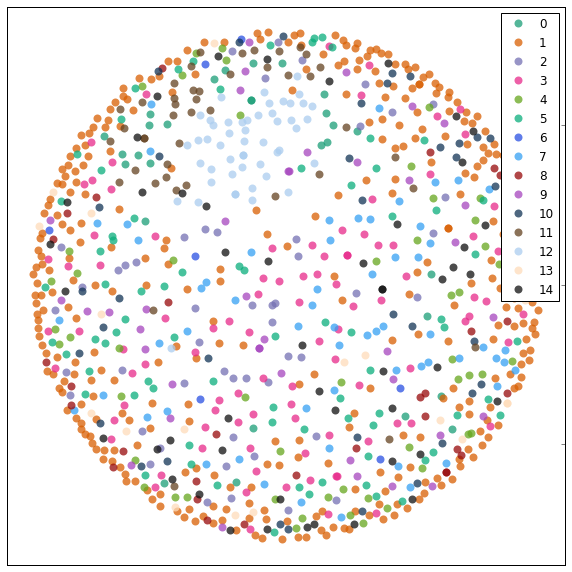

In [6]:
# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clustered_jokes_text['cluster'])) 

# group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' 
# lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', alpha=.75, linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  # show legend with only 1 point
  
plt.show() # show the plot

# uncomment the below to save the plot if need be
# plt.savefig('clusters_small_noaxes.png', dpi=200)

#### 4. More Visualization ####
As I was curious about how different $k$ values lead to different clustering results, I decided to make multiple plots with various $k$ values and show them side by side. In the plot below I set $k$ to $[1, 2, 3, 4, 5, 7, 10, 15, 20]$ respectively.   

As $k$ increase in value, one can see that all the colors are meshed together, and there's not really any clear boundaries between the clusters. This is more clearly shown with the plot directly above. I think this ties back to the feature selection question - maybe bag of words is not the best feature representation for jokes, since they tend to use largely similar vocabularies.

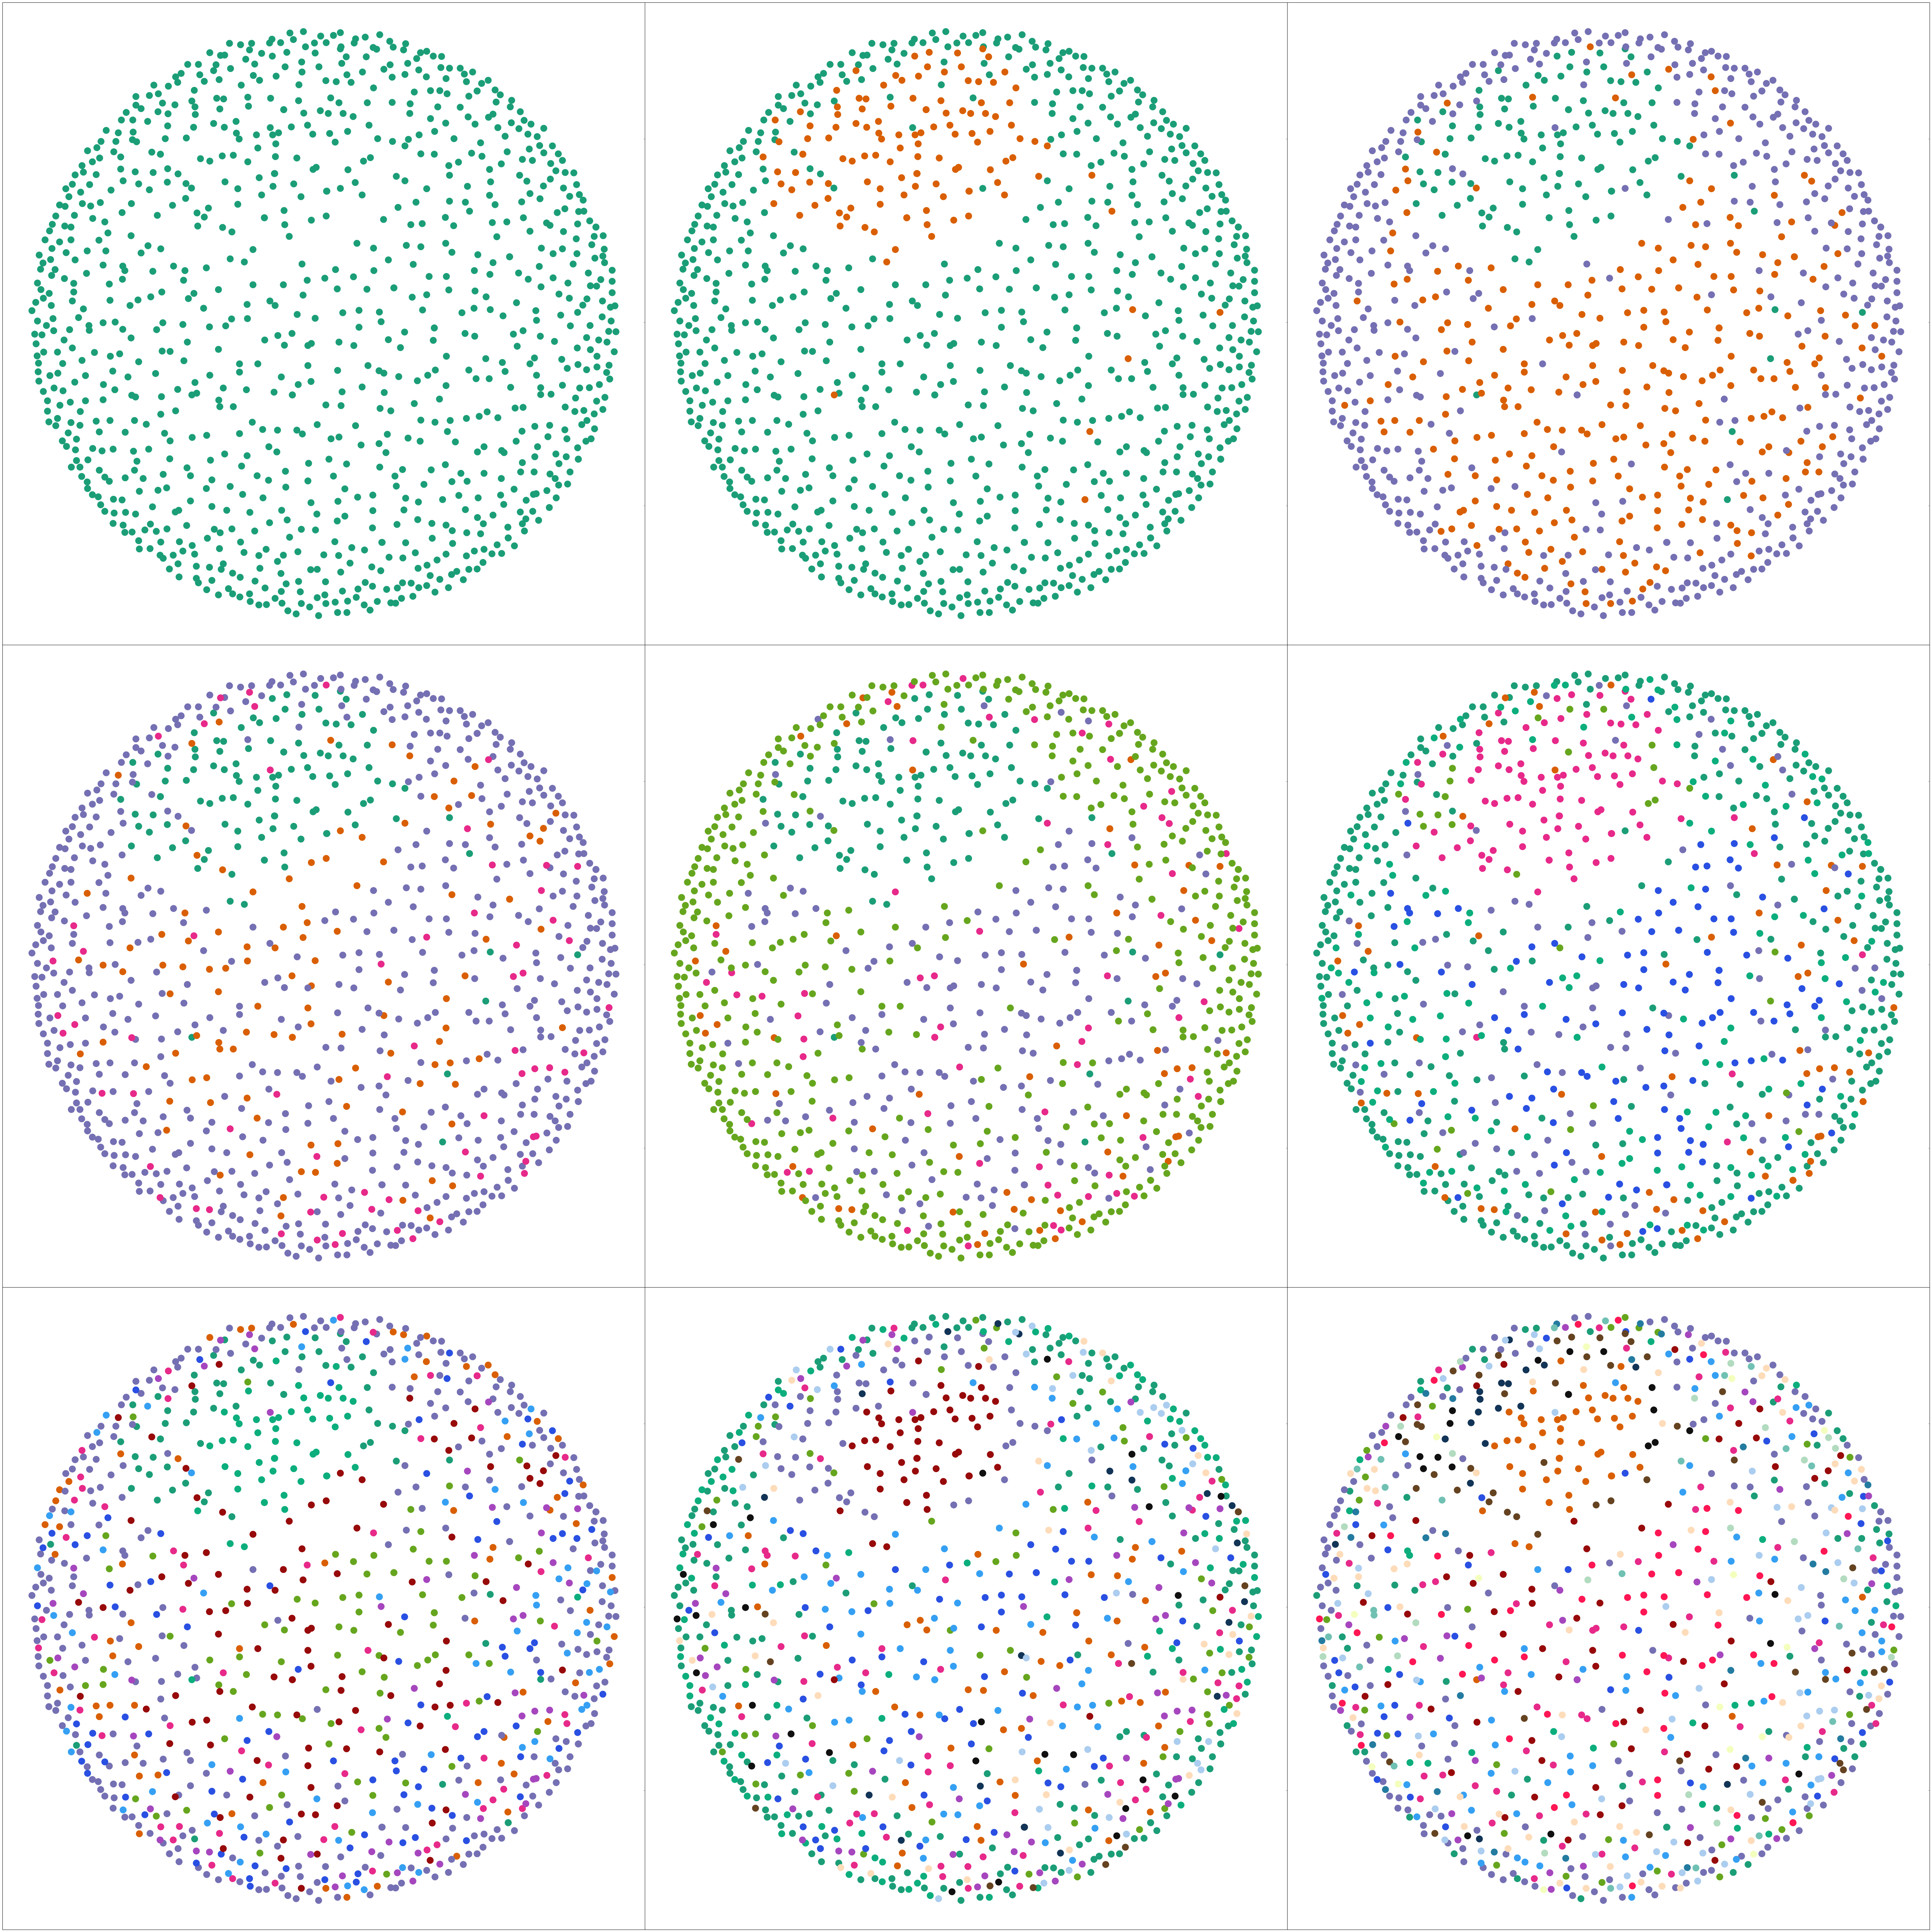

In [7]:
PRINT_VERBOSE = False

plt.figure(1)
fig, ax = plt.subplots(3, 3, figsize=(100, 100))
fig.subplots_adjust(wspace = 0, hspace = 0)
num_clusters = [1, 2, 3, 4, 5, 7, 10, 15, 20]

for i in range(9):
    n = num_clusters[i]
    clustered_jokes_text = k_means(data, n)
    df = pd.DataFrame(dict(x=xs, y=ys, label=clustered_jokes_text['cluster'])) 
    groups = df.groupby('label')
    
    ax[int(i/3), i%3].margins(0.05) 
    for name, group in groups:
        ax[int(i/3), i%3].plot(group.x, group.y, marker='o', linestyle='', ms=20, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax[int(i/3), i%3].set_aspect('auto')
        ax[int(i/3), i%3].tick_params(\
                       axis= 'x',         # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom='off',      # ticks along the bottom edge are off
                       top='off',         # ticks along the top edge are off
                       labelbottom='off')
        ax[int(i/3), i%3].tick_params(\
                       axis= 'y',         # changes apply to the y-axis
                       which='both',      # both major and minor ticks are affected
                       left='off',        # ticks along the bottom edge are off
                       top='off',         # ticks along the top edge are off
                       labelleft='off')
        
plt.show()

***
### Latent Dirichlet Allocation ###

From Brandon Rose's [blog](http://brandonrose.org/clustering#K-means-clustering)
> ... using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics ...

I did not do too much tweaking in this section, and leveraged most of Brandon's code.  

It is interesting to see topic words outputted from a different method, especially with their corresponding probabilities. The output does not seem to be particularly more meaningful. For $k=15$, the topic words generated by k-means actually seems more meaningful to me. Additionally, LDA runs much slower than k-means.

In [8]:
# create a list of lists, where each list element is a list of words for a joke
# used for building lda model below
tokens = [word_tokenize(sent.lower()) for sent in jokes_data_list]
cachedStopWords = stopwords.words("english")
texts = [[word for word in sent if word not in cachedStopWords] for sent in tokens]

# create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.45)

# convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

# building lda
%time lda = models.LdaModel(corpus, num_topics=15, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

# show topics
lda.show_topics()

CPU times: user 3min 7s, sys: 2.41 s, total: 3min 9s
Wall time: 3min 19s


[(3,
  '0.015*"news" + 0.012*"one" + 0.011*"bull" + 0.010*"know" + 0.009*"back" + 0.008*"cow" + 0.007*"get" + 0.007*"would" + 0.007*"time" + 0.006*"still"'),
 (1,
  '0.011*"woman" + 0.010*"said" + 0.009*"say" + 0.009*"old" + 0.009*"man" + 0.008*"want" + 0.008*"cowboy" + 0.008*"know" + 0.007*"time" + 0.007*"like"'),
 (0,
  '0.024*"one" + 0.014*"man" + 0.011*"woman" + 0.008*"know" + 0.007*"tell" + 0.007*"sex" + 0.007*"little" + 0.007*"teacher" + 0.007*"like" + 0.007*"said"'),
 (9,
  '0.012*"drunk" + 0.010*"say" + 0.010*"frog" + 0.010*"one" + 0.009*"get" + 0.009*"take" + 0.008*"eye" + 0.007*"bill" + 0.007*"god" + 0.007*"pocket"'),
 (7,
  '0.020*"say" + 0.014*"mama" + 0.012*"dog" + 0.011*"man" + 0.011*"get" + 0.009*"fat" + 0.009*"dead" + 0.009*"tell" + 0.009*"love" + 0.007*"guy"'),
 (12,
  '0.020*"blonde" + 0.016*"get" + 0.014*"one" + 0.014*"like" + 0.013*"said" + 0.012*"car" + 0.011*"got" + 0.010*"say" + 0.009*"know" + 0.009*"little"'),
 (2,
  '0.018*"mama" + 0.013*"like" + 0.013*"course"

In [9]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for (cluster, words) in topics_matrix:
    print([word[0] for word in words])
    print()

['say', 'mama', 'dog', 'man', 'get', 'fat', 'dead', 'tell', 'love', 'guy', 'know', 'sex', 'woman', 'like', 'road', 'well', 'accident', 'going', 'nun', 'want']

['gun', 'two', 'say', 'guy', 'blah', 'man', 'nurse', 'asks', 'know', 'get', 'way', 'one', 'could', 'time', 'dog', 'bar', 'well', 'leg', 'people', 'pant']

['woman', 'said', 'say', 'old', 'man', 'want', 'cowboy', 'know', 'time', 'like', 'see', 'around', 'one', 'first', 'two', 'taste', 'guy', 'pant', 'ticket', 'blonde']

['drunk', 'say', 'frog', 'one', 'get', 'take', 'eye', 'bill', 'god', 'pocket', 'want', 'light', 'cat', 'back', 'like', 'life', 'wife', 'asked', 'engineer', 'shirt']

['man', 'mama', 'got', 'old', 'lot', 'salesman', 'last', 'woman', 'would', 'please', 'difference', 'stupid', 'ask', 'hot', 'good', 'six', 'farmhouse', 'said', 'car', 'something']

['say', 'look', 'like', 'guy', 'one', 'mama', 'computer', 'man', 'bartender', 'walk', 'asks', 'thing', 'three', 'order', 'bar', 'rancher', 'know', 'panda', 'cowboy', 'woman'

***

### Word Embeddings with Word2Vec ###  
For the word embeddings comparison I used the large pre-trained model from class. For list of nouns, verbs and adjectives, I chose the common terms from my text collection shown above.   

It seems to me that Word2Vec consistently outperforms WordNet in showing the concepts of a word. It gives out a more diverse set of related words, e.g. for 'blonde' it has 'brunette' as a similar word. WordNet on the other hand is more limited and rigid, as the synsets only show the strict senses of a word and does not explore its related concepts.

In [10]:
# train word2vec model
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary = False)

In [11]:
# print word concepts by word2vec and WordNet synsets
def print_word_embedding_comparison(words, word_type):
    print(word_type +' comparison')
    for word in words:
        print('='*20)
        print('word: ' + word)
        
        print('most similar words by Word2Vec: ', end = '')
        print([word for word, score in model.most_similar(word, topn = 5)])
        
        print('most similar words by WordNet: ', end = '')
        pos = 'n' if word_type.startswith('n') else ('v' if word_type.startswith('v') else 'a')
        synsets = wn.synsets(word, pos)
        words = ''
        
        # for each of the top 3 synsets, print out all the lemma names for that synset as a list
        for i in range(min(3, len(synsets))):
            words = words + '['
            for name in synsets[i].lemma_names():
                words = words + name + ', '
            words = words[:-2] + ']' + ', '
        print(words[:-2])
        
        print()

#### Nouns ####

In [12]:
list_of_nouns = ['bartender', 'woman', 'mama', 'sex', 'smuggling']
print_word_embedding_comparison(list_of_nouns, 'noun')

noun comparison
word: bartender
most similar words by Word2Vec: ['waitress', 'waiter', 'barkeep', 'doorman', 'tavern']
most similar words by WordNet: [bartender, barman, barkeep, barkeeper, mixologist]

word: woman
most similar words by Word2Vec: ['man', 'girl', 'teenager', 'lady', 'mother']
most similar words by WordNet: [woman, adult_female], [woman], [charwoman, char, cleaning_woman, cleaning_lady, woman]

word: mama
most similar words by Word2Vec: ['daddy', 'Momma', 'mom', 'Mama', 'grandma']
most similar words by WordNet: [ma, mama, mamma, mom, momma, mommy, mammy, mum, mummy], [Mama]

word: sex
most similar words by Word2Vec: ['sexual', 'intercourse', 'prostitution', 'Sex', 'sexually']
most similar words by WordNet: [sexual_activity, sexual_practice, sex, sex_activity], [sex], [sex, sexual_urge]

word: smuggling
most similar words by Word2Vec: ['smugglers', 'smuggled', 'smuggle', 'illicit', 'contraband']
most similar words by WordNet: [smuggling]



#### Verbs ####

In [13]:
list_of_verbs = ['drive', 'play', 'know', 'order', 'knock']
print_word_embedding_comparison(list_of_verbs, 'verb')

verb comparison
word: drive
most similar words by Word2Vec: ['drives', 'driving', 'drove', 'push', 'run']
most similar words by WordNet: [drive], [drive, motor], [drive]

word: play
most similar words by Word2Vec: ['playing', 'plays', 'played', 'game', 'games']
most similar words by WordNet: [play], [play], [play]

word: know
most similar words by Word2Vec: ['tell', 'think', 'do', 'understand', 'guess']
most similar words by WordNet: [know, cognize, cognise], [know], [know]

word: order
most similar words by Word2Vec: ['orders', 'ordering', 'ordered', 'necessary', 'directive']
most similar words by WordNet: [order, tell, enjoin, say], [order], [order, prescribe, dictate]

word: knock
most similar words by Word2Vec: ['knocking', 'knocks', 'knocked', 'blow', 'rattle']
most similar words by WordNet: [knock, strike_hard], [knock], [bump, knock]



#### Adjectives ####

In [14]:
list_of_adjs = ['blonde', 'nasty', 'dead', 'ugly', 'white']
print_word_embedding_comparison(list_of_adjs, 'adjective')

adjective comparison
word: blonde
most similar words by Word2Vec: ['blond', 'redhead', 'blondes', 'brunettes', 'redheaded']
most similar words by WordNet: [blond, blonde, light-haired]

word: nasty
most similar words by Word2Vec: ['ugly', 'vicious', 'nastiest', 'nastier', 'unpleasant']
most similar words by WordNet: [nasty, awful], [nasty, tight], [cruddy, filthy, foul, nasty, smutty]

word: dead
most similar words by Word2Vec: ['killed', 'murdered', 'died', 'corpses', 'wounded']
most similar words by WordNet: [dead], [dead], [all_in, beat, bushed, dead]

word: ugly
most similar words by Word2Vec: ['uglier', 'nasty', 'awful', 'hideous', 'horrible']
most similar words by WordNet: [ugly], [surly, ugly], [despicable, ugly, vile, slimy, unworthy, worthless, wretched]

word: white
most similar words by Word2Vec: ['black', 'blue', 'brown', 'colored', 'gray']
most similar words by WordNet: [white], [white], [white]

